# Epymorph dev log: May 3rd, 2023

_author: Tyler Coles_

_as of git hash: b1cc2663b422bfcbcc0768ab82639528f4e16438_

Let's demo running the Pei IPM with a few different movement models: no movement, ice cube tray movement, and the standard Pei-style movement. For each simulation, our infection will begin in Florida.

## Setup

In [ ]:
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

from epymorph.model.geo_pei import load_geo as load_pei_geo
from epymorph.model.ipm_pei import PeiModelBuilder
from epymorph.model.mvm_pei import load_mvm as load_pei_mvm
from epymorph.movement import load_movement_spec
from epymorph.simulation import Output, Simulation
from epymorph.util import stridesum

# Some default parameters to use.
param = {
    "theta": 0.1,
    "move_control": 0.9,
    "infection_duration": 4.0,
    "immunity_duration": 90.0,
    "infection_seed_loc": 0,
    "infection_seed_size": 10_000,
}


# This helper method constructs a sim by loading the specifed movement file.
def sim_from(mvm_file: str) -> Simulation:
    with open(mvm_file, "r") as file:
        spec_string = file.read()
        mvm_builder = load_movement_spec(spec_string)
        return Simulation(
            geo=load_pei_geo(), ipm_builder=PeiModelBuilder(), mvm_builder=mvm_builder
        )


# This helper method draws a plot of infection incidence vs time
# for all populations.
def plot_inf(out: Output) -> None:
    event = 0
    fig, ax = plt.subplots()
    ax.set_title("Infection incidence")
    ax.set_xlabel("days")
    ax.set_ylabel("infections")
    x_axis = list(range(out.ctx.clock.num_days))
    for pop_idx in range(out.ctx.nodes):
        values = stridesum(out.incidence[:, pop_idx, event], out.ctx.clock.num_steps)
        y_axis = values
        ax.plot(x_axis, y_axis, label=out.ctx.labels[pop_idx])
    ax.legend()
    fig.tight_layout()
    plt.show()

## No Movement

In the first example, our movement model always returns zero from the movement equation, so we expect the infection to remain in Florida.

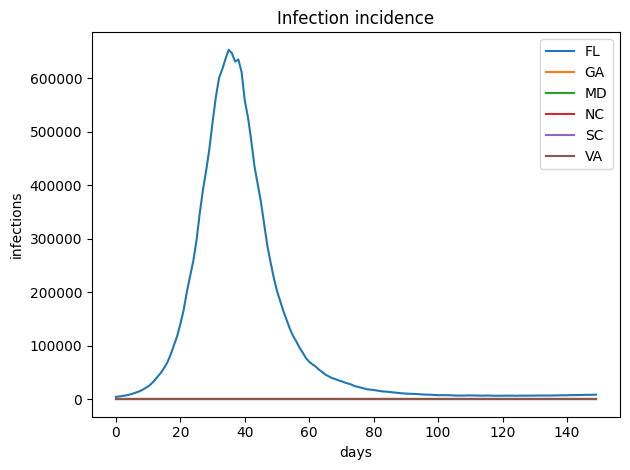

In [ ]:
plot_inf(
    sim_from("./data/no.movement").run(
        param=param,
        start_date=date(2023, 1, 1),
        duration_days=150,
        rng=np.random.default_rng(1),
    )
)

## "Ice cube tray" movement

The second example movement model returns a fixed number of commuters leaving from one state and traveling only to the next state (in the states list). So we would expect the infection to "spill over" sequentially from one state to the next, just like water filling an ice cube tray. Each state doesn't receive significant numbers of infected travelers until the infection is well-established in the previous state, which creates a delay based on its position in the list.

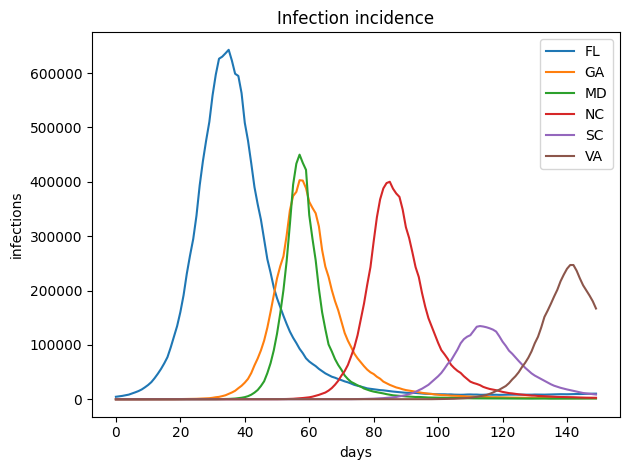

In [ ]:
plot_inf(
    sim_from("./data/icecube.movement").run(
        param=param,
        start_date=date(2023, 1, 1),
        duration_days=150,
        rng=np.random.default_rng(1),
    )
)

## Pei-inspired movement model

And finally we have the standard Pei-inspired model based on commuting data with random dispersers.

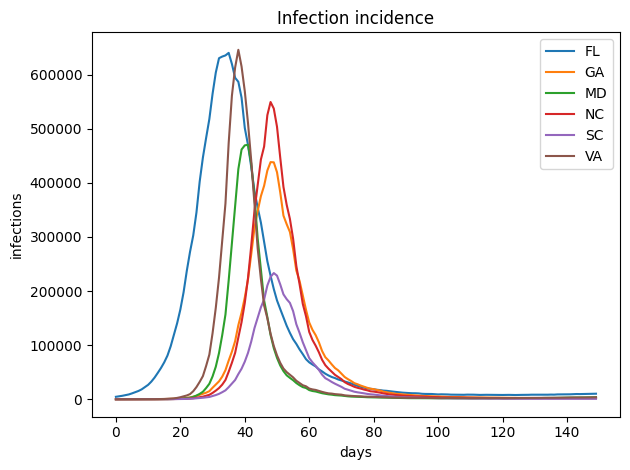

In [ ]:
plot_inf(
    sim_from("./data/pei.movement").run(
        param=param,
        start_date=date(2023, 1, 1),
        duration_days=150,
        rng=np.random.default_rng(1),
    )
)